In [1]:
import pandas as pd
import numpy as np
import os
import re
from quasinet.qnet import Qnet, qdistance, membership_degree, export_qnet_tree,load_qnet, qdistance_matrix, save_qnet
from quasinet.qsampling import qsample, targeted_qsample
import subprocess
EMBED='/home/ishanu/Dropbox/ZED/Research/data_smashing_/bin/embed '
import seaborn as sns
import random
from tqdm import tqdm
from pqdm.processes import pqdm                                                                     
from sklearn import metrics
import pylab as plt
from sklearn.decomposition import PCA


In [2]:
df=pd.read_csv('../data/CAD-PTSDData.csv',index_col=0)
df1=df[df.PTSDDx==1]
df0=df[df.PTSDDx==0]
df0=df0.sample(86)
df=pd.concat([df0,df1])

In [3]:
X = df.drop('PTSDDx',axis=1).values.astype(str)[:]

In [4]:
qnet = Qnet(n_jobs=12,feature_names=df.drop('PTSDDx',axis=1).columns.values).fit(X)

In [5]:
save_qnet(qnet,'catptsd_balanced1.joblib')

In [6]:
qnet=load_qnet('catptsd_balanced1.joblib')

In [7]:
out_dirname='./'
for idx, feature_name in enumerate(qnet.feature_names):
            export_qnet_tree(qnet, idx,
            os.path.join(out_dirname, '{}_balanced.dot'.format(feature_name)),
            outformat='graphviz', detailed_output=False)

In [8]:
# test qdistance calculation
seq1 = X[1]
seq2 = X[2]

qdist = qdistance(seq1, seq2,qnet,qnet) 
qdist

0.15599474121666043

In [9]:
# generate distanec matrix
H=qdistance_matrix(X,X, qnet, qnet)

pd.DataFrame(H).to_csv('HMAT_balanced1.csv',index=None,header=None,sep=' ')
H.shape

(172, 172)

In [10]:
# calculate sippl embedding

PREF='./'
FILE='HMAT_balanced1.csv'
DATAFILE=FILE#'data_'
EFILE=PREF+'_Eb1_'
DFILE=PREF+'_Db1_'
PCAEFILE=PREF+'_PEb1_'

In [11]:
STR=EMBED+' -f '+DATAFILE+' -E '+EFILE+' -D '+DFILE
subprocess.call(STR,shell=True);

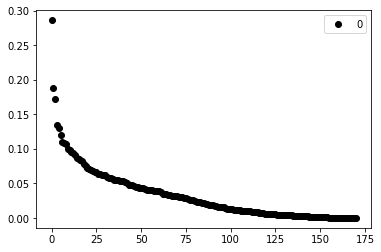

In [12]:
# plot dimensional error
pd.read_csv(DFILE,sep=' ',header=None).transpose().plot(style='ko')

In [13]:
# get embedding matrix
E=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
E.columns=['x'+str(i) for i in E.columns]
E.to_csv('Eb1.csv')

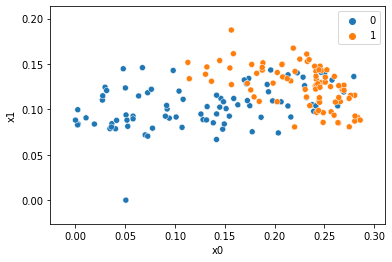

In [14]:
# scatterplot of emedding, colored with DX
sns.scatterplot(E.x0,E.x1,hue=df.PTSDDx.values)

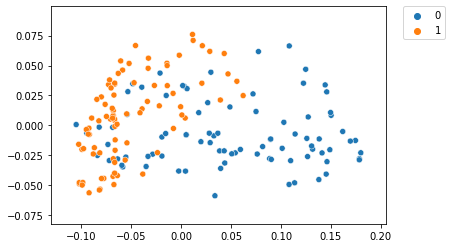

In [15]:
Ef=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
Ef.columns=['x'+str(i) for i in Ef.columns]
xf=Ef#.assign(IF=dx.ido)

pca = PCA(n_components=2).fit(xf)
ef=pca.fit_transform(xf)

pd.DataFrame(ef).to_csv(PCAEFILE,header=None,index=None)

sns.scatterplot(x=ef[:,0],y=ef[:,1],hue=df.PTSDDx);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

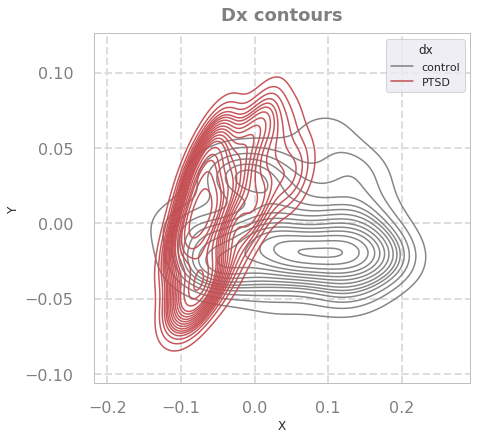

In [16]:
def varname(x):
    if x:
        return 'PTSD'
    return 'control'
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(ef,columns=['X','Y']).assign(ido=df.PTSDDx.values)
pf['dx']=(pf.ido>0)
pf['dx']=[varname(x) for x in pf.dx]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,hue='dx',thresh=.05,palette=['.5','r'],fontsize=16)

ax.set_title('Dx contours',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig('dxcontour_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [17]:
# the null response
s_null=['']*len(X[0])
D_null=qnet.predict_distributions(s_null)

In [18]:
def getMaskedSample(s,cols,mutable_vars,
                    mask_prob=0.5,
                    allow_all_mutable=False):
    '''
    Get random masked sample, with mask_prob fraction masked
    '''
    MUTABLE=pd.DataFrame(np.zeros(len(cols)),index=cols).transpose()
    WITHVAL=[x for x in cols[np.where(s)[0]] if x in mutable_vars ]
    MASKrand=[x for x in WITHVAL if random.random() > mask_prob ]
    for m in MASKrand:
        MUTABLE[m]=1.0
            
    mutable_x=MUTABLE.values[0]
    base_frequency=mutable_x/mutable_x.sum()
    
    s1=s.copy()
    for i in range(len(base_frequency)):
        if base_frequency[i]>0.0001:
            s1[i]=''
            
    s_rand=np.copy(s)
    rnd_match_prob=[]        
    max_match_prob=[]        
    D=qnet.predict_distributions(s)
    for i in MASKrand:
        s_rand[np.where(
            cols==i)[0][0]]=choose_one(
                D_null[np.where(cols==i)[0][0]].keys())
        rnd_match_prob=np.append(rnd_match_prob,1/len(
            D_null[np.where(cols==i)[0][0]].keys()))
        max_match_prob=np.append(
            max_match_prob,np.max(
                list(D[np.where(
                    cols==i)[0][0]].values())))
        
    if allow_all_mutable:
        for m in mutable_vars:
            MUTABLE[m]=1.0
        mutable_x=MUTABLE.values[0]
        base_frequency=mutable_x/mutable_x.sum()

    return s1,base_frequency,MASKrand,np.where(
        base_frequency)[0],np.mean(rnd_match_prob),np.mean(max_match_prob),s_rand

def choose_one(X):
    X=list(X)
    if len(X)>0:
        return X[np.random.randint(len(X))]
    return None

samples=None
def getRecon(index,MEAN=True):
    s=samples[index]
    
    s1,bp,mask_,maskindex,rmatch_u,rmatch,s_rand=getMaskedSample(s,cols,
                                                                     mutable_vars,
                                                                     mask_prob=MASKPROB)
    qs=qsample(s1,qnet,Nsteps,bp)
    recondf=pd.DataFrame([s,qs,s_rand],columns=cols,index=['s','q','r'])[mask_].transpose()
    recondf=recondf.replace('',np.nan).dropna(axis=0).astype(float)
    recondf['delta']=recondf.s-recondf.q
    if MEAN:
        return recondf.delta.mean()
    return recondf

In [19]:
# Reconstruction parameters

cols=qnet.feature_names
mutable_vars=cols
MASKPROB=.018
Nsteps=12000

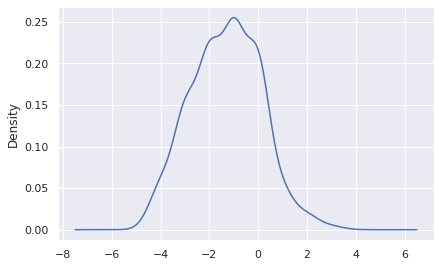

In [20]:
samples=X
#getDissonance(0)

getRecon(0,MEAN=False).delta.plot.kde()

In [21]:
samples=X
Recon=pqdm(range(len(X)), getRecon, n_jobs=12)                                                              
DF=pd.DataFrame(Recon,columns=['recon'])
DF
DF.to_csv('Recon3_balanced1.csv')
DF=pd.read_csv('Recon3_balanced1.csv',index_col=0)
DF=DF.join(df.PTSDDx.reset_index()).set_index('record_id')

In [22]:
print(DF[DF.PTSDDx==1].recon.mean(),DF[DF.PTSDDx==0].recon.mean())

0.28500857916455724 -0.7871754107224674


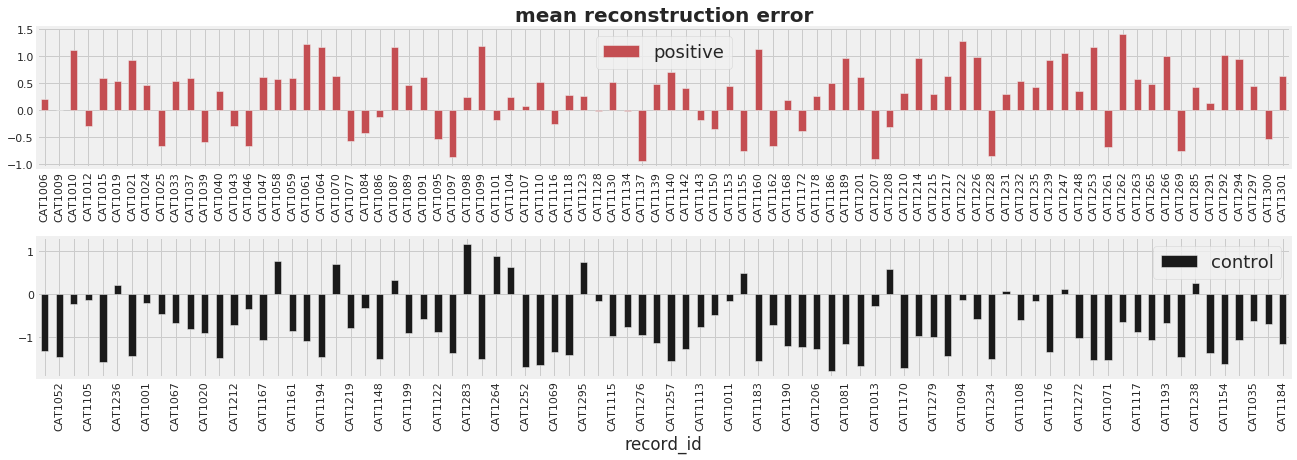

In [23]:
plt.figure(figsize=[20,6])
plt.style.use('fivethirtyeight')
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.5)
DF[DF.PTSDDx==1].recon.plot(kind='bar',color='r')
plt.gca().set_xlabel('')
ax0=plt.gca()
plt.subplot(2,1,2)
DF[DF.PTSDDx==0].recon.plot(kind='bar',color='k')
ax=plt.gca()
#plt.setp(ax.get_xticklabels(), fontsize=10);
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax0.set_title('mean reconstruction error',fontsize=20,fontweight='bold');
ax0.legend(['positive'],fontsize=18)
ax.legend(['control'],fontsize=18)

plt.savefig('recosntruction_3_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

## conclusions
+ we achieve small reconstruction error with a very few items revealed (2.5% ie 5)

In [24]:
def getDissonance(sample_index,index=None,MISSING_VAL=0.0):                                  
    '''                                                                                               
    Dissonnace vector                                                                                                   
    '''  
    if isinstance(sample_index, int):
        s=samples[sample_index]                                                                           
    else:
        s=sample_index
    if index is None:                                                                                 
        index=range(len(s))                                                                           
                                                                                                      
    Ds=qnet.predict_distributions(s)                                                                  
                                                                                                      
    diss=np.ones(len(Ds))*MISSING_VAL                                                                 
    for i in index:                                                                                   
        if s[i] != '':                                                                                
            if s[i] in Ds[i].keys():                                                                  
                diss[i]=1-Ds[i][s[i]]/np.max(                                                         
                    list(Ds[i].values()))                                                             
            else:                                                                                     
                diss[i]=1.0                                                                           
                                                                                                      
    return diss                                                                        

In [25]:
samples=X
from pqdm.processes import pqdm                                                                     
Diss=pqdm(range(len(X)), getDissonance, n_jobs=12)                                                              
Diss=pd.DataFrame(Diss)

0.2065702928583109


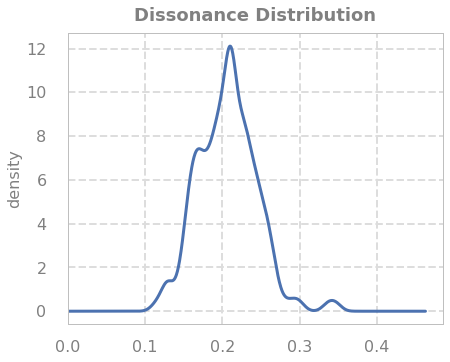

In [26]:
print(Diss.mean(axis=1).mean())

fig=plt.figure(figsize=[6,5])
sns.set()

ax=plt.gca()


Diss.mean(axis=1).plot.kde(bw_method=0.2,lw=3)


ax.set_title('Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
plt.gca().set_xlim(0,None)
ax.set_ylabel('density',fontsize=16,color='.5')


plt.savefig('dissonance_dist_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [27]:
DF1=DF.join(pd.DataFrame(Diss.mean(axis=1),columns=['dissonance']).set_index(DF.index))
DF1.corr()

,recon,PTSDDx,dissonance
recon,1.000000,0.628089,0.022168
PTSDDx,0.628089,1.000000,-0.101490
dissonance,0.022168,-0.101490,1.000000


In [28]:
# generate random responses
Xrand=[(np.random.randint(5,size=len(X[0]))+1).astype(str) for i in range(200)]

In [29]:
# compute dissonance for random responses
samples=Xrand
from pqdm.processes import pqdm                                                                     
Dissrand=pqdm(range(len(Xrand)), getDissonance, n_jobs=12)                                                              
Dissrand=pd.DataFrame(Dissrand)

0.43220844667123465 0.023731563040452142


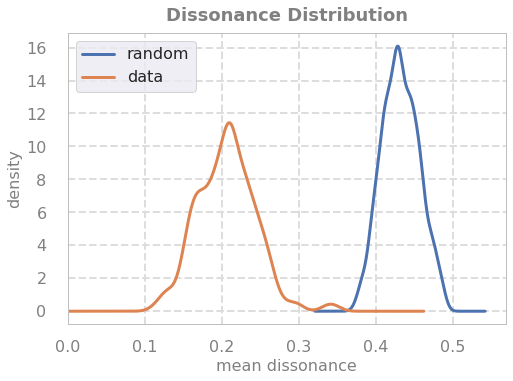

In [30]:
print(Dissrand.mean(axis=1).mean(),Dissrand.mean(axis=1).std())

fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()


Dissrand.mean(axis=1).plot.kde(bw_method=0.25,lw=3,label='random')
Diss.mean(axis=1).plot.kde(ax=ax,bw_method=0.25,lw=3,label='data')

ax.set_title('Dissonance Distribution',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
plt.gca().set_xlim(0,None)
ax.set_ylabel('density',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance',fontsize=16,color='.5')
ax.legend(fontsize=16)

plt.savefig('dissonance_dist_rand_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [31]:
samples=Xrand
Reconrand=pqdm(range(len(Xrand)), getRecon, n_jobs=12)                                                              

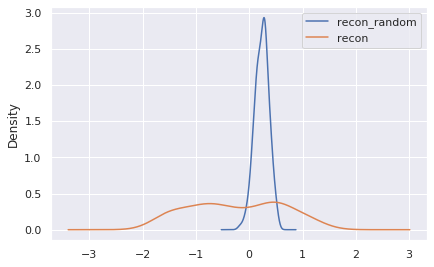

In [32]:
DF=pd.DataFrame(Recon,columns=['recon'])
DFrand=pd.DataFrame(Reconrand,columns=['recon_random'])
ax=DFrand.plot.kde()
DF.plot.kde(ax=ax)

{0, 1}


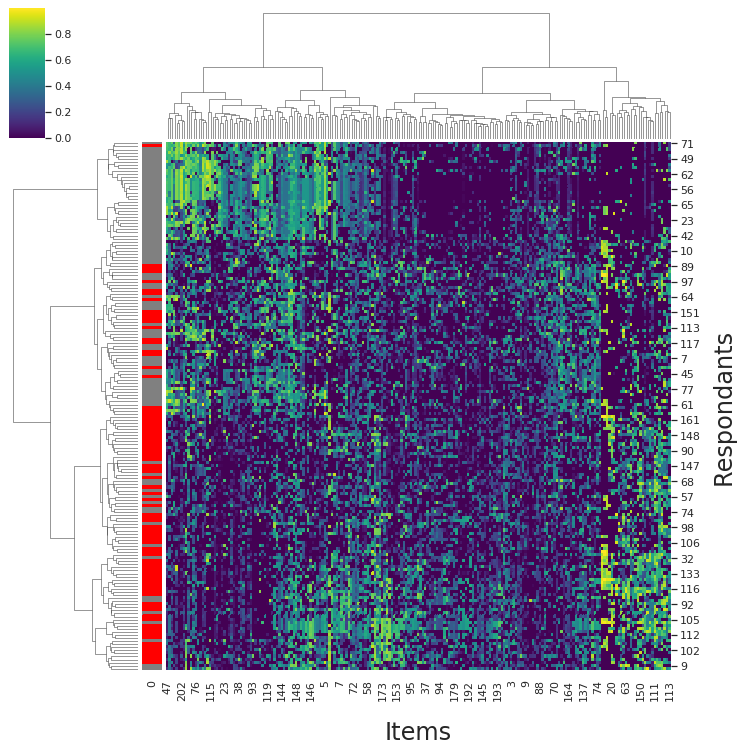

In [33]:
import seaborn as sns
labels = DF1.PTSDDx.values
lut = dict(zip(set(labels), ['.5','red']))
row_colors = pd.DataFrame(labels)[0].map(lut)

cm=sns.clustermap(Diss,method='ward',row_colors=row_colors,cmap='viridis')
cm.ax_heatmap.set_xlabel('Items',fontsize=24,labelpad=20)
cm.ax_heatmap.set_ylabel('Respondants',fontsize=24,labelpad=10)
print(set(labels))

plt.savefig('clsmap_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

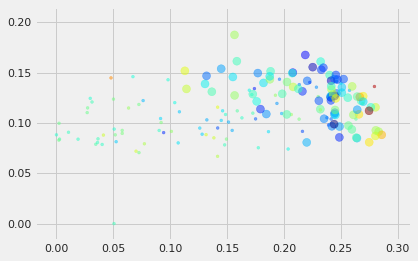

In [34]:
#sns.scatterplot(E.x0,E.x1,hue=DS.diss,cmap='jet')
plt.style.use('fivethirtyeight')
plt.scatter(E.x0,E.x1,c=DF1.dissonance,cmap='jet',s=2**(3*(DF1.PTSDDx+1)),alpha=.5)

0.4403731746890211
0.8597214710654408


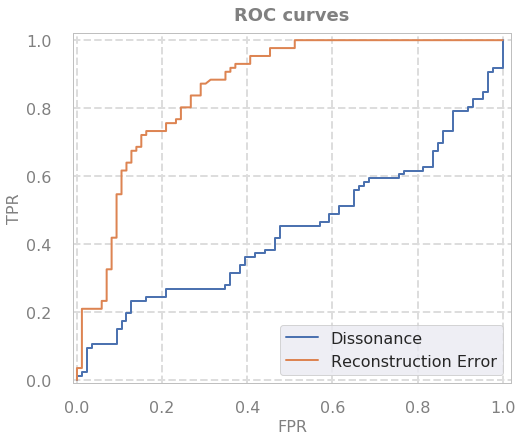

In [35]:
fig=plt.figure(figsize=[7,6])
sns.set()

ax=plt.gca()

fpr, tpr, thresholds = metrics.roc_curve(DF1.PTSDDx.values,DF1.dissonance, pos_label=1)
print(metrics.auc(fpr, tpr))

fpr1, tpr1, thresholds1 = metrics.roc_curve(DF1.PTSDDx.values,DF1.recon, pos_label=1)
print(metrics.auc(fpr1, tpr1))

plt.plot(fpr,tpr,lw=2,label='dissonance')
plt.plot(fpr1,tpr1,lw=2,label='recon error')
plt.gca().legend()
plt.gca().set_xlim(-0.01,1.02)
plt.gca().set_ylim(-0.01,1.02)

ax.set_title('ROC curves',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
plt.gca().set_ylim(-0.01,1.02)
plt.gca().set_xlim(-0.01,1.02)
ax.set_ylabel('TPR',fontsize=16,color='.5')
ax.set_xlabel('FPR',fontsize=16,color='.5')
ax.legend(['Dissonance','Reconstruction Error'],fontsize=16)

plt.savefig('ROC_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)

0.43220844667123465 0.023731563040452142


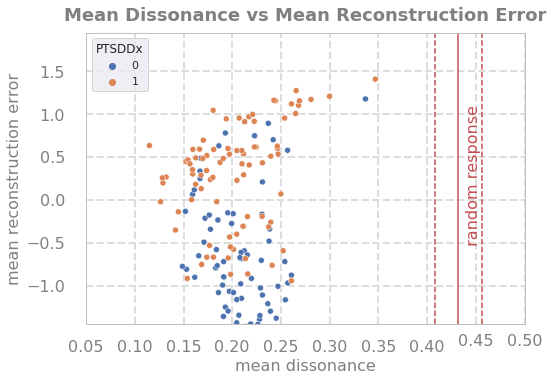

In [36]:
fig=plt.figure(figsize=[7,5])
sns.set()

ax=plt.gca()

#DF1.plot.scatter(ax=ax,x='dissonance',y='recon',cmap='seismic',c='PTSDDx')
sns.scatterplot(ax=ax,x='dissonance',y='recon',cmap='seismic',hue='PTSDDx',data=DF1)

ax.set_title('Mean Dissonance vs Mean Reconstruction Error',fontsize=18,fontweight='bold',y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
plt.gca().set_ylim(-1.45,1.95)
plt.gca().set_xlim(0.05,.5)
ax.set_ylabel('mean reconstruction error',fontsize=16,color='.5')
ax.set_xlabel('mean dissonance',fontsize=16,color='.5')
#ax.legend(fontsize=16)

print(Dissrand.mean(axis=1).mean(),Dissrand.mean(axis=1).std())

plt.plot(Dissrand.mean(axis=1).mean()*np.array([1,1]),[-1.45,1.95],'-r')
plt.plot((Dissrand.mean(axis=1).mean()-Dissrand.mean(axis=1).std())*np.array([1,1]),[-1.45,1.95],'--r')
plt.plot((Dissrand.mean(axis=1).mean()+Dissrand.mean(axis=1).std())*np.array([1,1]),[-1.45,1.95],'--r')

ax.text(s='random response',x=.44,y=-0.50,rotation=90,fontsize=16,color='r')

plt.savefig('dissrecon_balanced1'+'.png',dpi=600,bbox_inches='tight',transparent=True)





In [37]:
DF1.sort_values('dissonance',ascending=False).head()

,recon,PTSDDx,dissonance
record_id,,,
CAT1262,1.410628,1,0.346794
CAT1283,1.179612,0,0.336746
CAT1061,1.210784,1,0.299835
CAT1007,-1.514423,0,0.291835
CAT1099,1.173913,1,0.280840
